# Detector Head: Master Train

This is the "master-configuration" training of the "head" of the detector, namely the RPN (Region Proposal Network, which is based on feature-maps from a pre-trained Resnet) and the small location-based network.
The "head" model yielded from this notebook is used as starting-point for training of the complete-network (i.e. including the Resnet-based feature-extractor).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import DetectorNetwork as dn

import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from collections import Counter, OrderedDict
import cv2
from PIL import Image

import torch as t
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim

In [3]:
mpl.rcParams.update({'font.size': 14})

In [4]:
MODELS_PATH = Path('models')
HEAD_NAME = 'head_10images.mdl'
SAVE_MODEL = None # HEAD_NAME
LOAD_MODEL = HEAD_NAME

In [5]:
# train head
head_loss = dn.experiment_instance(exp_name='master', models_path=MODELS_PATH, save_model=SAVE_MODEL, load_model=LOAD_MODEL,
                                   train_plot_freq=4, verbose=2)
head_loss.head()


Experiment:	master
(291600, 12) (291600, 4, 12) (291600, 4)
Param-groups to set grad for: 48
cuda:0
Feature-map shape: torch.Size([1, 128, 135, 240])
Feature size: 8
Features shape:
Without location:	 torch.Size([1, 128, 135, 240])
	4<=x0<=1916, 4<=y0<=1076
With location:	 torch.Size([1, 130, 135, 240])
Network channels: 128 -> (skipped) -> 128 -> 45
Total params:	153457
Param-groups to set grad for: 10


,experiment,image,out_of_sample,loss_type,loss
0,master,0,False,Bkg detection,0.000027
1,master,1,False,Bkg detection,0.000058
2,master,2,False,Bkg detection,0.000037
3,master,3,False,Bkg detection,0.000049
4,master,4,False,Bkg detection,0.000045


In [6]:
# load head
head = dn.RPN(in_channels=128, loc_features=True, verbose=True)
head.load_state_dict(t.load(MODELS_PATH/HEAD_NAME))

Network channels: 128 -> (skipped) -> 128 -> 45


In [7]:
# Load stuff for scripting
# Images
files, images, W, H, i_used_images = dn.get_training_images(verbose=False)
inputs = dn.ims2vars(images, verbose=False)
# Labels
labels, locations, anchors = dn.get_training_labels(labs_path=r'labels/anchor_labels_9.pkl', verbose=True)
# Feature map
conv = dn.get_resnet_conv_model()
dn.set_grad(conv, 0, verbose=True)
inputs, labels, locations = dn.to_device(conv, inputs, labels, locations)
features = []
for file, X in zip(files, inputs):
    ft, map_h, map_w, feature_size = dn.get_features(X, conv, W, verbose=(file==files[0]))
    features.append(ft)
features = dn.add_location_to_features(features, anchors)
loc_fac = dn.LocationFactory(anchors, H, W)

(291600, 12) (291600, 4, 12) (291600, 4)
Param-groups to set grad for: 48
cuda:0
Feature-map shape: torch.Size([1, 128, 135, 240])
Feature size: 8
Features shape:
Without location:	 torch.Size([1, 128, 135, 240])
	4<=x0<=1916, 4<=y0<=1076
With location:	 torch.Size([1, 130, 135, 240])


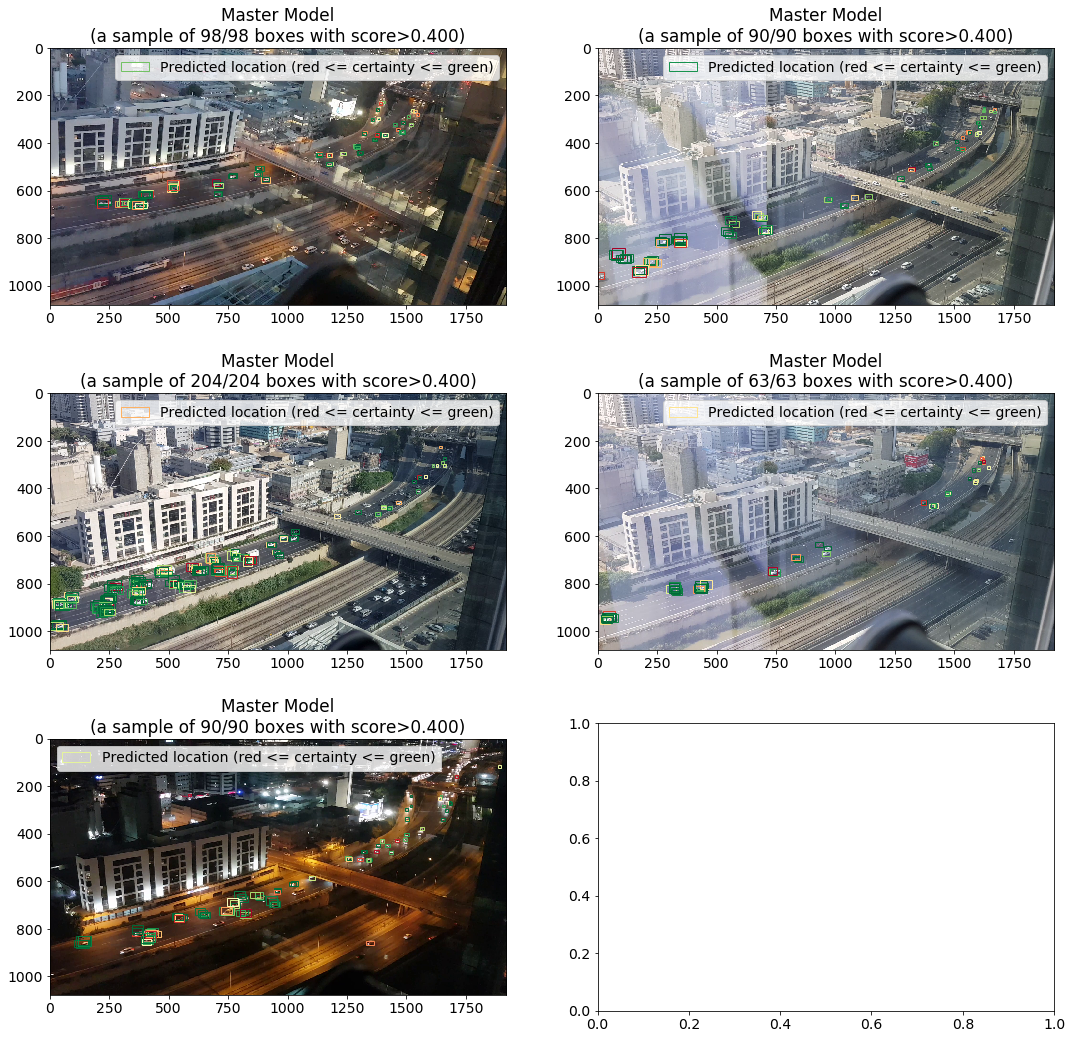

In [8]:
# show model final predictions
_, axs = plt.subplots(3,2, figsize=(18,18))

for ii,i in enumerate((1,6,8,10,11)):
    with t.no_grad():
        labs, locs = head(features[i])
    dn.show_preds(labs, locs, loc_fac, image=images[i], thresh=0.4,
                  n_display=np.Inf, ax=axs[ii//2,ii%2], title='Master Model')